In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
#loading in data
df = pd.read_csv('../bank-additional-full.csv', sep = ';')

#labeling the data, x as the features and y as the target variable
X = df.drop('y', axis = 1)
y = df['y'].map({'yes': 1, 'no': 0})

In [3]:
#finding the variables that are categorical and the ones that are numerical
categorical_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns

print(categorical_cols)
print(numeric_cols)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [ ]:

preprocessor = ColumnTransformer( 
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)
#here I am doing the preprocessing steps to prepare the data, specifically one hot encoding the categorical variables

In [5]:
rf = RandomForestClassifier(random_state = 1) #loading in random forest and choosing a random state

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

In [6]:
param_grid = { #grid for hyper parameter tuning
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1, stratify = y
)

In [8]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   5.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   5.9s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   5.9s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   6.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   6.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=  10.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   4.8s
[CV] END model__max_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')),
                                                                        ('num',
                                                                         'passthrough',
                                                                         Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [9]:
print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_

#predictions
y_pred = best_model.predict(X_test)

#evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best parameters found: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Accuracy: 0.9141781985918912

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.69      0.43      0.53       928

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.91      8238


Confusion Matrix:
 [[7129  181]
 [ 526  402]]


AUC: 0.9392954119298081


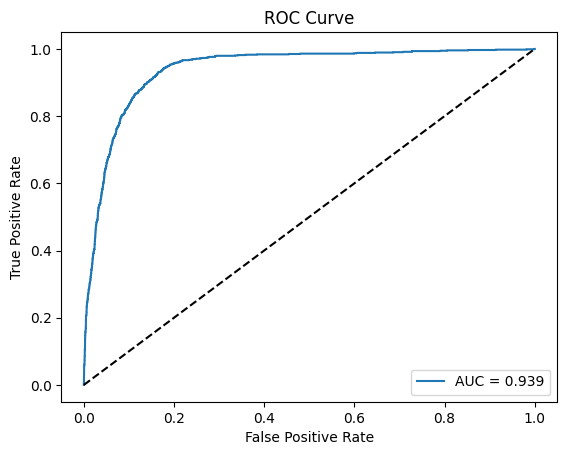

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#predict probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]
#compute the AUC
auc = roc_auc_score(y_test, y_proba)
print("AUC:", auc)

#Plotting the AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [12]:
# -------------------- SHAP Feature Importance (Optimized) --------------------
import shap
import numpy as np

# Extract trained RandomForest model
rf_model = best_model.named_steps['model']

# Preprocess X_test
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)

# Convert to dense array if sparse
if hasattr(X_test_preprocessed, "toarray"):
    X_test_preprocessed = X_test_preprocessed.toarray()

# Sample a subset of rows for faster SHAP computation
sample_size = 1000  # adjust as needed
if X_test_preprocessed.shape[0] > sample_size:
    X_sample = X_test_preprocessed[:sample_size]
else:
    X_sample = X_test_preprocessed

# Get feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

# -------------------- Global Feature Importance --------------------

# Summary dot plot
shap.summary_plot(shap_values[1], X_sample, feature_names=feature_names)

# Summary bar plot (mean absolute SHAP value)
shap.summary_plot(shap_values[1], X_sample, feature_names=feature_names, plot_type="bar")

# -------------------- Example Individual Prediction --------------------
# Force plot for the first sample
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    X_sample[0],
    feature_names=feature_names
)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.